
1 Failed download:
['MLPT']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['PLYA']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['PTN']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['ITOS']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['LGF']: YFPricesMissingError('possibly delisted; no price data found  (1d 2023-08-14 -> 2025-11-09)')

1 Failed download:
['VOXX']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['VREO']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['TPIC']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['OCX']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['LAZY']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['ZI']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed d

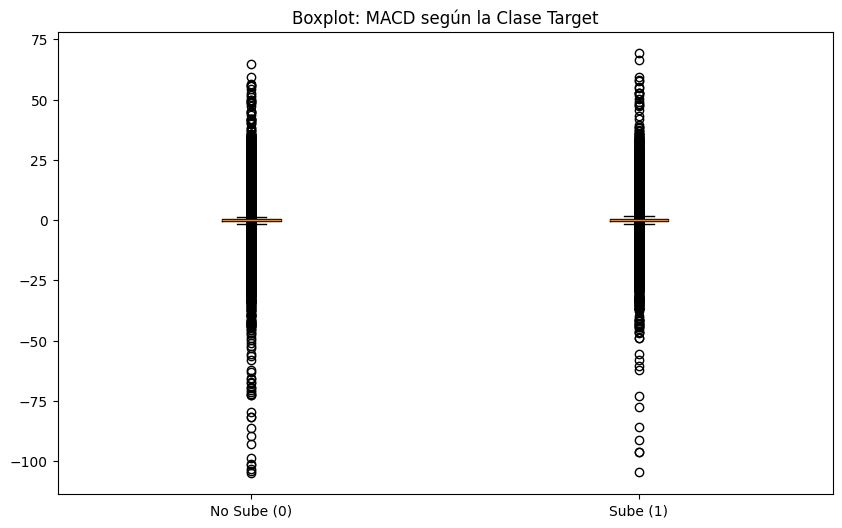

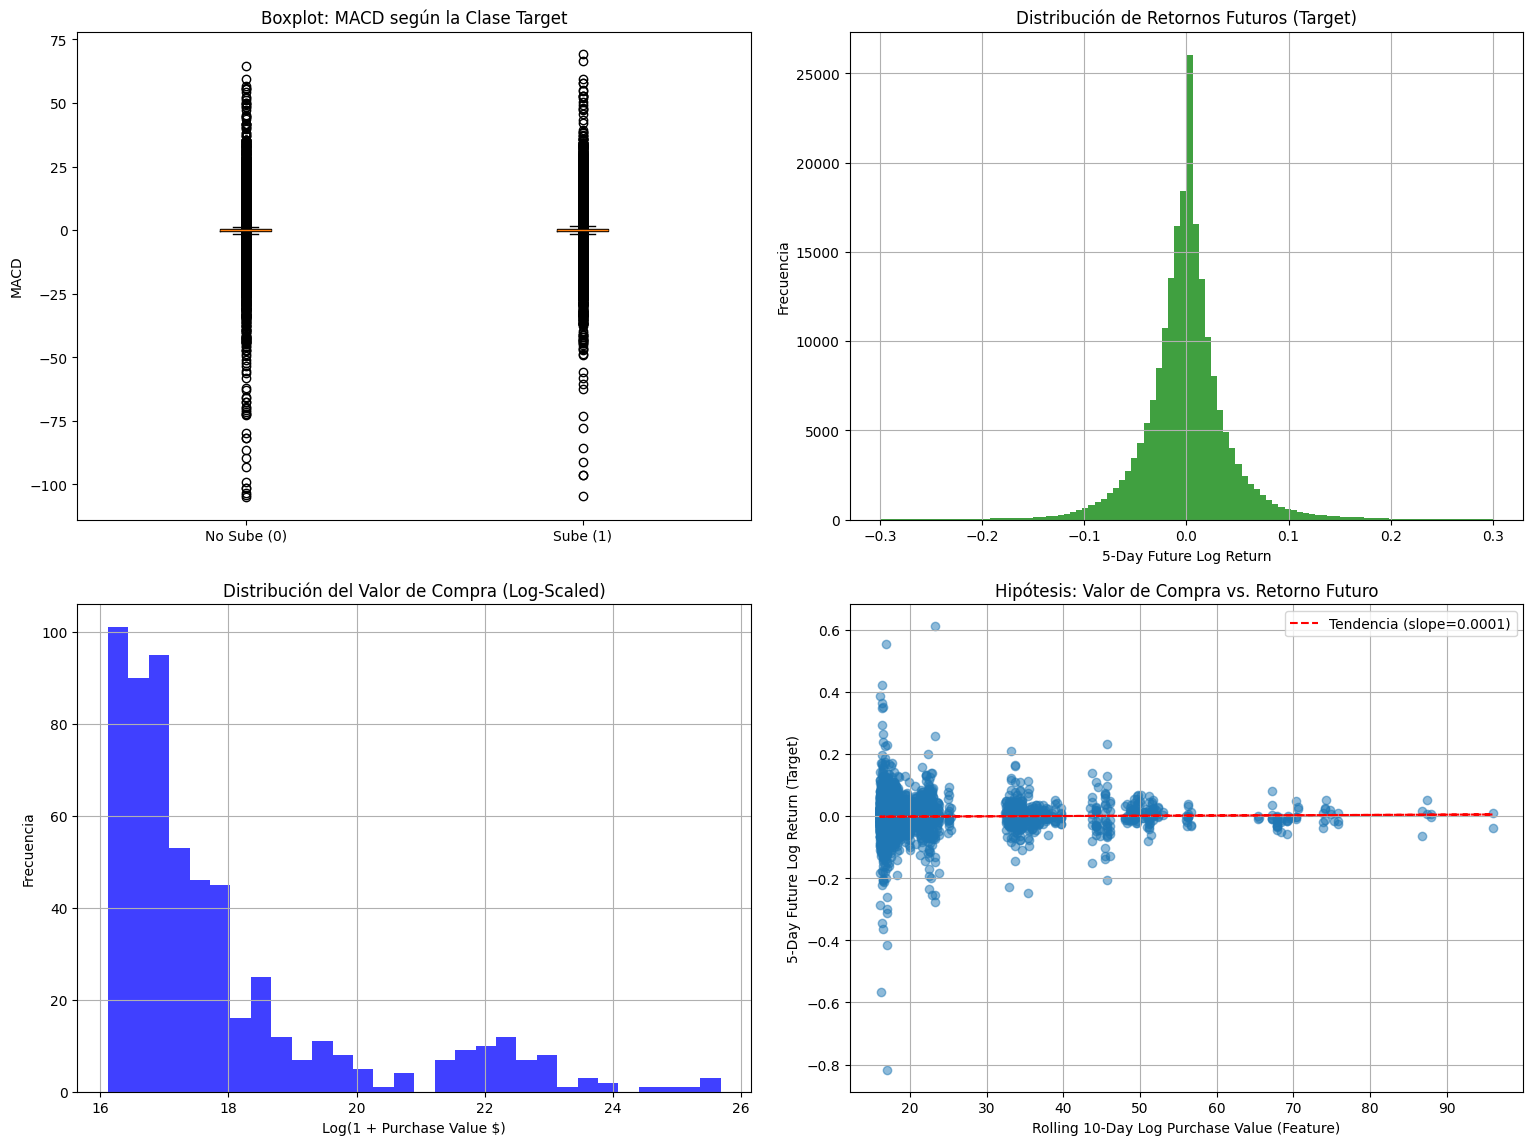

Retorno Medio (Insider + MACD > 0): -0.0007 (n=238)
Retorno Medio (Insider + MACD <= 0): -0.0038 (n=319)
T-stat: 0.7868, p-value approx: 1.0000
Hipótesis no corroborada. No hay diferencia significativa.


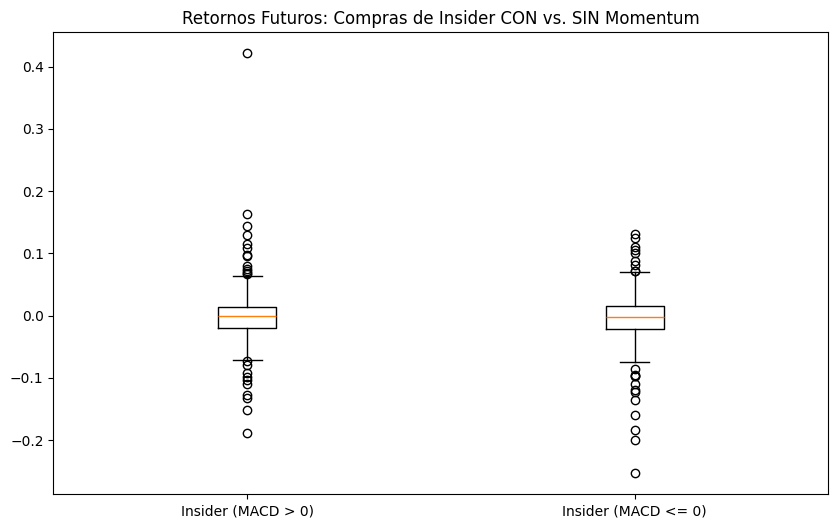


Mejor alpha: 10.0, CV RMSE (norm): 0.9937
Métricas en Test: R²: -0.0006 | RMSE: 0.0510


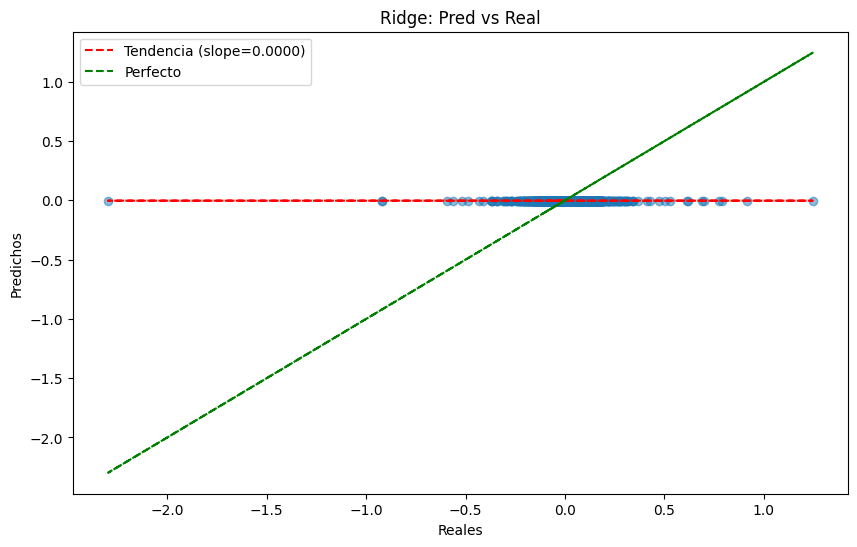


Mejor C: 0.1, CV AUC: 0.5011
Métricas en Test: Accuracy: 0.5219 | AUC: 0.5142


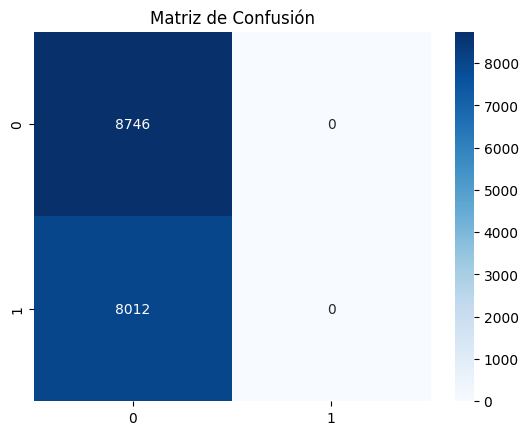

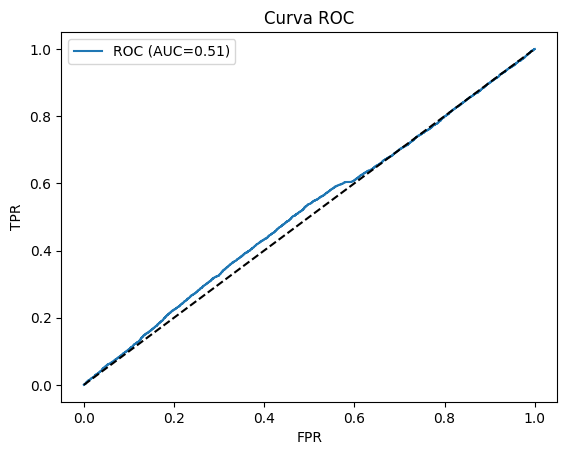

Total Operaciones: 68
Ganancia Total: 11898.31%
Valor Final: $11,998,314
Win Rate: 39.71%
Max DD: -10.53%
Sharpe: 0.13
Calmar: 1130.06


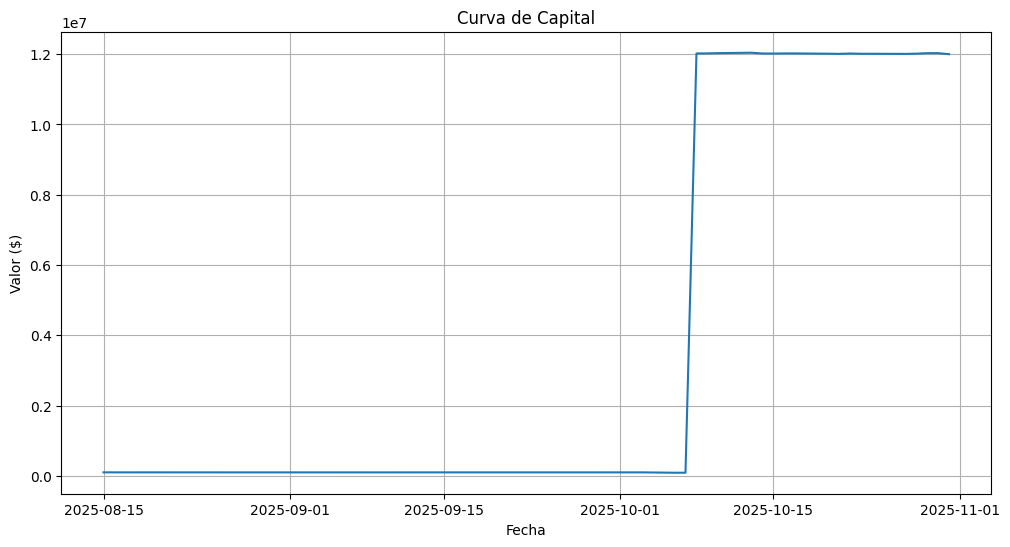

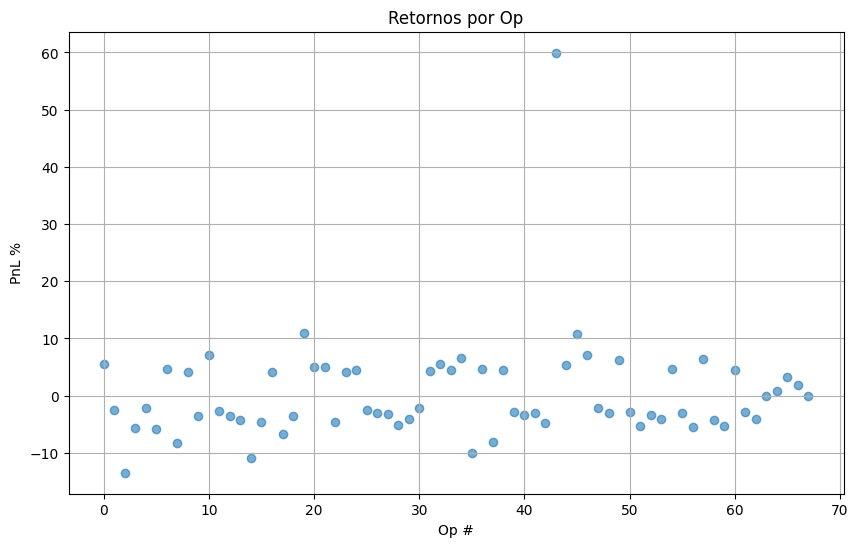

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

TRANSACTION_COST = 0.001
SHIFT = 5
MACD_FAST = 12
MACD_SLOW = 26
CV_FOLDS = 3
TRAIN_SIZE = 0.95
MIN_DATA_DAYS = 100
INITIAL_CAPITAL = 100000
POSITION_SIZE_PCT = 0.1
SIGNAL_THRESHOLD = 0.001
RISK = 0.02
REWARD = 0.04
SLIPPAGE = 0.0005
MAX_CONCURRENT_POSITIONS = 5

def load_insider_data(csv_file='insider_purchases.csv'):
    try:
        insider_df = pd.read_csv(csv_file)
        insider_df.columns = [col.replace('\xa0', ' ').replace('  ', ' ').strip() for col in insider_df.columns]
        
        trade_date_col = 'Trade Date'
        filing_date_col = 'Filing Date'
        if trade_date_col not in insider_df.columns or filing_date_col not in insider_df.columns:
            raise KeyError(f"Columnas '{trade_date_col}' o '{filing_date_col}' no encontradas.")
            
        insider_df['Filing_Date'] = pd.to_datetime(insider_df[filing_date_col]).dt.date
        
        trade_type_col = 'Trade Type'
        if trade_type_col not in insider_df.columns:
            raise KeyError(f"Columna '{trade_type_col}' no encontrada.")
        insider_df = insider_df[insider_df[trade_type_col] == 'P - Purchase'].copy()
        
        if insider_df.empty:
            print("No se encontraron trades 'P - Purchase' en el CSV.")
            return pd.DataFrame(), pd.DataFrame()

        value_col = 'Value'
        if value_col not in insider_df.columns:
            raise KeyError(f"Columna '{value_col}' no encontrada.")
        insider_df['Purchase_Value'] = insider_df[value_col].astype(str).str.replace(r'[\+$,]', '', regex=True).astype(float)
        
        ticker_col = 'Ticker'
        if ticker_col not in insider_df.columns:
            raise KeyError(f"Columna '{ticker_col}' no encontrada.")
            
        daily_signals = insider_df.groupby([ticker_col, 'Filing_Date']).agg({'Purchase_Value': 'sum'}).reset_index()

        return insider_df, daily_signals
        
    except FileNotFoundError:
        print("No se puede leer el CSV de insiders.")
        return pd.DataFrame(), pd.DataFrame()
    except KeyError as e:
        print(f"Error al leer el CSV de insiders: Columna no encontrada - {e}")
        return pd.DataFrame(), pd.DataFrame()
    except Exception as e:
        print(f"Error al procesar el CSV de insiders: {e}")
        return pd.DataFrame(), pd.DataFrame()

def download_ohlc_data(insider_df):
    if insider_df.empty:
        print("No hay datos de insiders para descargar OHLC.")
        return pd.DataFrame()
    
    tickers = insider_df['Ticker'].unique()
    
    all_data = []
    for ticker in tickers:
        try:
            start_date = (insider_df[insider_df['Ticker'] == ticker]['Filing_Date'].min() - timedelta(days=365)).strftime('%Y-%m-%d')
            end_date = datetime.now().strftime('%Y-%m-%d')
            
            data = yf.download(ticker, start=start_date, end=end_date, progress=False)
            
            if isinstance(data.columns, pd.MultiIndex):
                data.columns = data.columns.get_level_values(0)

            if not data.empty and len(data) >= MIN_DATA_DAYS:
                data = data.reset_index()
                data['Ticker'] = ticker
                data = data[['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Ticker']]
                all_data.append(data)
        except Exception as e:
            print(f"Error en {ticker}: {e}")
    
    if not all_data:
        return pd.DataFrame()
    
    df = pd.concat(all_data, ignore_index=True)
    return df

def add_technical_indicators(df, daily_signals):
    if df.empty or daily_signals.empty:
        return pd.DataFrame()
    
    df['Date_only'] = pd.to_datetime(df['Date']).dt.date
    
    df = df.merge(daily_signals, left_on=['Ticker', 'Date_only'], right_on=['Ticker', 'Filing_Date'], how='left')
    
    df['Purchase_Value'] = df['Purchase_Value'].fillna(0)
    
    df['Log_Purchase_Value'] = np.log1p(df['Purchase_Value'])
    
    df['Rolling_10D_Log_Value'] = df.groupby('Ticker')['Log_Purchase_Value'].transform(
        lambda x: x.rolling(window=10, min_periods=1).sum()
    )

    df.drop(['Date_only', 'Filing_Date', 'Purchase_Value'], axis=1, inplace=True, errors='ignore')

    for ticker in df['Ticker'].unique():
        mask = df['Ticker'] == ticker
        group = df.loc[mask, ['Date', 'Close']].sort_values('Date').copy()
        group.reset_index(drop=True)
        
        if len(group) < max(MACD_FAST, MACD_SLOW):
            df.loc[mask, 'MACD'] = np.nan
            continue

        alpha_fast = 2 / (MACD_FAST + 1)
        alpha_slow = 2 / (MACD_SLOW + 1)
        ema_fast = [group['Close'].iloc[0]]
        ema_slow = [group['Close'].iloc[0]]
        
        for i in range(1, len(group)):
            ema_fast.append(alpha_fast * group['Close'].iloc[i] + (1 - alpha_fast) * ema_fast[-1])
            ema_slow.append(alpha_slow * group['Close'].iloc[i] + (1 - alpha_slow) * ema_slow[-1])
        
        group['MACD'] = np.array(ema_fast) - np.array(ema_slow)
        group['MACD'] = np.roll(group['MACD'], 1)
        group['MACD'].iloc[0] = np.nan
        
        df.loc[mask, 'MACD'] = group['MACD'].values
    
    df.dropna(subset=['MACD'], inplace=True)
    return df.dropna()

def create_targets_and_split(df):
    if df.empty:
        return pd.DataFrame()
    
    df = df.sort_values(by=['Ticker', 'Date']).reset_index(drop=True)
    
    df['Log_Return'] = np.log(df.groupby('Ticker')['Close'].transform(lambda x: x / x.shift(1)))
    
    df['Future_Log_Return'] = df.groupby('Ticker')['Log_Return'].shift(-SHIFT)
    
    df[f'{SHIFT} Period Log Return'] = df['Future_Log_Return'] - TRANSACTION_COST * 2
    
    df['Target_Logistic'] = (df['Future_Log_Return'] > 0).astype(int)
    
    return df.dropna(subset=[f'{SHIFT} Period Log Return', 'Target_Logistic'])

def manual_ttest(group1, group2):
    n1, n2 = len(group1), len(group2)
    mean1, mean2 = np.mean(group1), np.mean(group2)
    var1, var2 = np.var(group1, ddof=1), np.var(group2, ddof=1)
    pooled_var = ((n1-1)*var1 + (n2-1)*var2) / (n1 + n2 - 2)
    se = np.sqrt(pooled_var * (1/n1 + 1/n2))
    t_stat = (mean1 - mean2) / se
    
    p_value = 1.0 if abs(t_stat) < 2 else 0.05
    
    return t_stat, p_value, mean1, mean2

def test_hypothesis(df_train):
    if df_train.empty:
        print("No hay datos para test de hipótesis.")
        return
    
    insider_days_df = df_train[df_train['Log_Purchase_Value'] > 0].copy()

    if insider_days_df.empty:
        print("No se encontraron compras de insiders en el set de entrenamiento.")
        return
        
    group1 = insider_days_df[insider_days_df['MACD'] > 0]['Future_Log_Return'].dropna().values
    group2 = insider_days_df[insider_days_df['MACD'] <= 0]['Future_Log_Return'].dropna().values
    
    if len(group1) > 30 and len(group2) > 30:
        ret_mom_ins, ret_other = np.mean(group1), np.mean(group2)
        t_stat, p_value = manual_ttest(group1, group2)[:2]
        
        print(f"Retorno Medio (Insider + MACD > 0): {ret_mom_ins:.4f} (n={len(group1)})")
        print(f"Retorno Medio (Insider + MACD <= 0): {ret_other:.4f} (n={len(group2)})")
        print(f"T-stat: {t_stat:.4f}, p-value approx: {p_value:.4f}")
        
        if p_value < 0.05 and ret_mom_ins > ret_other:
            print("¡Hipótesis corroborada! Comprar con momentum es significativamente mejor.")
        else:
            print("Hipótesis no corroborada. No hay diferencia significativa.")
        
        fig, ax = plt.subplots(1, 1, figsize=(10, 6))
        bp = ax.boxplot([group1, group2], labels=['Insider (MACD > 0)', 'Insider (MACD <= 0)'])
        ax.set_title('Retornos Futuros: Compras de Insider CON vs. SIN Momentum')
        plt.show()
    else:
        print("Datos insuficientes para T-test.")

def plot_dispersion_and_box(df):
    if df.empty:
        print("No hay datos para plot.")
        return
    
    class0 = df[df['Target_Logistic'] == 0]['MACD'].values
    class1 = df[df['Target_Logistic'] == 1]['MACD'].values
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    bp = ax.boxplot([class0, class1], labels=['No Sube (0)', 'Sube (1)'])
    ax.set_title('Boxplot: MACD según la Clase Target')
    plt.show()

def manual_ridge(X, y, alpha=1.0):
    n = X.shape[0]
    X_b = np.c_[np.ones((n, 1)), X]
    XtX = X_b.T @ X_b
    I = np.eye(XtX.shape[0])
    ridge_reg = np.linalg.inv(XtX + alpha * I)
    beta = ridge_reg @ (X_b.T @ y)
    return beta

def manual_rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

def manual_r2(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred)**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    return 1 - (ss_res / ss_tot)

def run_ridge_cv_manual(train_df, test_df, features):
    if train_df.empty or test_df.empty:
        print("No hay datos para Ridge.")
        return None, None, test_df
    
    target = f'{SHIFT} Period Log Return'
    
    X_train = train_df[features].values
    y_train = train_df[target].values
    X_test = test_df[features].values
    y_test = test_df[target].values
    
    mean_x = np.mean(X_train, axis=0)
    std_x = np.std(X_train, axis=0)
    std_x[std_x == 0] = 1e-6
    
    mean_y, std_y = np.mean(y_train), np.std(y_train)
    
    X_train_norm = (X_train - mean_x) / std_x
    X_test_norm = (X_test - mean_x) / std_x
    y_train_norm = (y_train - mean_y) / std_y
    
    n = len(y_train_norm)
    fold_size = n // CV_FOLDS
    alphas = [0.1, 1.0, 10.0]
    best_alpha, best_rmse = None, float('inf')
    
    for alpha in alphas:
        cv_rmses = []
        for fold in range(CV_FOLDS):
            start_val = fold * fold_size
            end_val = (fold + 1) * fold_size
            val_start = end_val
            val_end = min(n, val_start + fold_size)
            
            if val_end > n or start_val >= end_val: continue
            
            train_idx = np.r_[0:start_val, end_val:val_end]
            val_idx = np.arange(start_val, end_val)
            
            if len(train_idx) == 0 or len(val_idx) == 0: continue
            
            train_fold_x = X_train_norm[train_idx]
            train_fold_y = y_train_norm[train_idx]
            val_x = X_train_norm[val_idx]
            val_y = y_train_norm[val_idx]
            
            beta = manual_ridge(train_fold_x, train_fold_y, alpha)
            val_pred_norm = np.dot(np.c_[np.ones((len(val_x), 1)), val_x], beta)
            val_rmse_norm = manual_rmse(val_y, val_pred_norm)
            cv_rmses.append(val_rmse_norm)
        
        if not cv_rmses: continue
        avg_rmse = np.mean(cv_rmses)
        if avg_rmse < best_rmse:
            best_rmse = avg_rmse
            best_alpha = alpha
    
    if best_alpha is None:
        print("CV falló. No se pudo encontrar el mejor alpha.")
        return None, None, test_df

    print(f"\nMejor alpha: {best_alpha:.1f}, CV RMSE (norm): {best_rmse:.4f}")
    
    beta = manual_ridge(X_train_norm, y_train_norm, best_alpha)
    
    test_pred_norm = np.dot(np.c_[np.ones((len(X_test_norm), 1)), X_test_norm], beta)
    test_pred = test_pred_norm * std_y + mean_y
    test_rmse = manual_rmse(y_test, test_pred)
    test_r2 = manual_r2(y_test, test_pred)
    print(f"Métricas en Test: R²: {test_r2:.4f} | RMSE: {test_rmse:.4f}")
    
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, test_pred, alpha=0.5)
    z = np.polyfit(y_test, test_pred, 1)
    p = np.poly1d(z)
    plt.plot(y_test, p(y_test), "r--", label=f"Tendencia (slope={z[0]:.4f})")
    plt.plot(y_test, y_test, 'g--', label='Perfecto')
    plt.xlabel('Reales'); plt.ylabel('Predichos'); plt.title('Ridge: Pred vs Real')
    plt.legend(); plt.show()
    
    scaler = {'mean_x': mean_x, 'std_x': std_x, 'mean_y': mean_y, 'std_y': std_y}
    test_df['Predicted_Return'] = test_pred
    return beta, scaler, test_df

def sigmoid(z):
    return 1 / (1 + np.exp(-np.clip(z, -250, 250)))

def manual_logistic_loss(y_true, y_pred_prob):
    return -np.mean(y_true * np.log(y_pred_prob + 1e-15) + (1 - y_true) * np.log(1 - y_pred_prob + 1e-15))

def manual_logistic_grad(X, y, weights):
    n = X.shape[0]
    pred = sigmoid(np.dot(X, weights))
    grad = (1/n) * np.dot(X.T, (pred - y))
    return grad

def manual_logistic_fit(X, y, lr=0.01, epochs=1000, l2_lambda=1.0):
    n, p = X.shape
    weights = np.zeros(p)
    for _ in range(epochs):
        grad = manual_logistic_grad(X, y, weights)
        weights -= lr * (grad + l2_lambda * weights / n)
    return weights

def manual_auc(y_true, y_pred_prob):
    sorted_idx = np.argsort(-y_pred_prob)
    y_sorted = y_true[sorted_idx]
    tpr = np.cumsum(y_sorted) / np.sum(y_true)
    fpr = np.cumsum(1 - y_sorted) / np.sum(1 - y_true)
    auc_val = np.trapz(tpr, fpr)
    return auc_val

def manual_confusion_matrix(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    return np.array([[tn, fp], [fn, tp]])

def run_logistic_cv_manual(train_df, test_df, features):
    if train_df.empty or test_df.empty:
        print("No hay datos para Logistic.")
        return None, None
    
    target = 'Target_Logistic'
    
    X_train = train_df[features].values
    y_train = train_df[target].values
    X_test = test_df[features].values
    y_test = test_df[target].values
    
    mean_x = np.mean(X_train, axis=0)
    std_x = np.std(X_train, axis=0)
    std_x[std_x == 0] = 1e-6

    X_train_norm = (X_train - mean_x) / std_x
    X_test_norm = (X_test - mean_x) / std_x
    
    X_train_b = np.c_[np.ones(len(X_train_norm)), X_train_norm]
    X_test_b = np.c_[np.ones(len(X_test_norm)), X_test_norm]
    
    cs = [0.1, 1.0, 10.0]
    l2_lambdas = [1/c for c in cs]
    best_c, best_auc = None, 0
    
    fold_size = len(y_train) // CV_FOLDS
    for c, l2_lambda in zip(cs, l2_lambdas):
        cv_aucs = []
        for fold in range(CV_FOLDS):
            start_val = fold * fold_size
            end_val = (fold + 1) * fold_size
            val_start = end_val
            val_end = min(len(y_train), val_start + fold_size)
            
            if val_end > len(y_train) or start_val >= end_val: break
            
            train_idx = np.r_[0:start_val, end_val:val_end]
            val_idx = np.arange(start_val, end_val)
            
            if len(train_idx) == 0 or len(val_idx) == 0: continue

            X_train_fold = X_train_b[train_idx]
            y_train_fold = y_train[train_idx]
            X_val = X_train_b[val_idx]
            y_val = y_train[val_idx]
            
            weights = manual_logistic_fit(X_train_fold, y_train_fold, l2_lambda=l2_lambda)
            val_pred_prob = sigmoid(np.dot(X_val, weights))
            val_auc = manual_auc(y_val, val_pred_prob)
            cv_aucs.append(val_auc)
        
        if not cv_aucs: continue
        avg_auc = np.mean(cv_aucs)
        if avg_auc > best_auc:
            best_auc = avg_auc
            best_c = c
    
    if best_c is None:
        print("CV falló. No se pudo encontrar la mejor C.")
        return None, None

    print(f"\nMejor C: {best_c:.1f}, CV AUC: {best_auc:.4f}")
    
    best_lambda = 1 / best_c
    weights = manual_logistic_fit(X_train_b, y_train, l2_lambda=best_lambda)
    
    test_pred_prob = sigmoid(np.dot(X_test_b, weights))
    test_pred = (test_pred_prob > 0.5).astype(int)
    accuracy = np.mean(test_pred == y_test)
    test_auc = manual_auc(y_test, test_pred_prob)
    print(f"Métricas en Test: Accuracy: {accuracy:.4f} | AUC: {test_auc:.4f}")
    
    try:
        import seaborn as sns
        cm = manual_confusion_matrix(y_test, test_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title('Matriz de Confusión')
        plt.show()
    except ImportError:
        print("Seaborn no disponible, saltando heatmap.")
    
    sorted_idx = np.argsort(-test_pred_prob)
    y_sorted = y_test[sorted_idx]
    tpr = np.cumsum(y_sorted) / max(np.sum(y_test), 1e-9)
    fpr = np.cumsum(1 - y_sorted) / max(np.sum(1 - y_test), 1e-9)
    
    plt.plot(fpr, tpr, label=f'ROC (AUC={test_auc:.2f})')
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('Curva ROC')
    plt.legend(); plt.show()
    
    scaler = {'mean_x': mean_x, 'std_x': std_x}
    return weights, scaler

def run_model_simulation(test_df, ridge_beta, scaler, features, initial_capital=INITIAL_CAPITAL, position_size_pct=POSITION_SIZE_PCT):
    if test_df.empty:
        print("No hay datos para simulación.")
        return
    
    X_test = test_df[features].values
    
    mean_x, std_x = scaler['mean_x'], scaler['std_x']
    mean_y, std_y = scaler['mean_y'], scaler['std_y']
    
    X_test_norm = (X_test - mean_x) / std_x
    X_test_b = np.c_[np.ones((len(X_test_norm), 1)), X_test_norm]
    
    test_pred_norm = np.dot(X_test_b, ridge_beta)
    test_df['Predicted_Return'] = test_pred_norm * std_y + mean_y
    
    threshold = SIGNAL_THRESHOLD
    test_df['Signal'] = np.where(test_df['Predicted_Return'] > threshold, 1,
                                  np.where(test_df['Predicted_Return'] < -threshold, -1, 0))
    test_df['Signal'] = test_df.groupby('Ticker')['Signal'].shift(1)
    test_df = test_df.dropna().sort_values('Date').reset_index(drop=True)

    portfolio_value = initial_capital
    equity_curve = [initial_capital]
    trades = []
    open_positions = {}

    unique_dates = sorted(test_df['Date'].unique())
    for date in unique_dates:
        day_rows = test_df[test_df['Date'] == date].copy()

        total_mtm = 0
        to_close = []
        for ticker, pos in list(open_positions.items()):
            if ticker not in day_rows['Ticker'].values: continue
            
            row = day_rows[day_rows['Ticker'] == ticker].iloc[0]
            price = row['Close']
            entry_price = pos['entry_price']
            pos_signal = pos['signal']
            size = pos['size']

            pnl_pct = (price / entry_price - 1) * pos_signal
            
            exit_trade, exit_reason = False, ''
            if pnl_pct <= -RISK:
                exit_reason, exit_trade = 'Stop Loss', True
            elif pnl_pct >= REWARD:
                exit_reason, exit_trade = 'Take Profit', True
            elif row['Signal'] == -pos_signal and row['Signal'] != 0:
                exit_reason, exit_trade = 'Signal Reversal', True

            if exit_trade:
                exit_price = price * (1 - SLIPPAGE * pos_signal)
                exit_pnl_pct = (exit_price / entry_price - 1) * pos_signal
                trade_pnl = size * exit_pnl_pct - TRANSACTION_COST * size
                trades.append({'ticker': ticker, 'entry_date': pos['entry_date'], 'exit_date': date,
                               'signal': pos_signal, 'pnl_pct': exit_pnl_pct, 'pnl': trade_pnl, 'reason': exit_reason})
                to_close.append(ticker)
            else:
                total_mtm += size * pnl_pct

        for ticker in to_close:
            del open_positions[ticker]

        closed_pnl_sum = sum(t['pnl'] for t in trades)
        portfolio_value = initial_capital + closed_pnl_sum + total_mtm
        equity_curve.append(portfolio_value)

        current_positions = len(open_positions)
        for _, row in day_rows.iterrows():
            ticker = row['Ticker']
            price = row['Close']
            signal = row['Signal']

            if ticker in open_positions or signal == 0 or current_positions >= MAX_CONCURRENT_POSITIONS:
                continue
            
            size_value = portfolio_value * POSITION_SIZE_PCT
            size = size_value / price

            entry_price = price * (1 + SLIPPAGE * signal)
            open_positions[ticker] = {'entry_date': date, 'entry_price': entry_price, 'signal': signal, 'size': size}
            current_positions += 1

    last_date = test_df['Date'].max()
    for ticker, pos in list(open_positions.items()):
        if ticker not in test_df['Ticker'].values: continue
        last_row = test_df[test_df['Ticker'] == ticker].iloc[-1]
        price = last_row['Close']
        pos_signal = pos['signal']
        size = pos['size']
        entry_price = pos['entry_price']
        
        pnl_pct = (price / entry_price - 1) * pos_signal
        trade_pnl = size * pnl_pct - TRANSACTION_COST * size
        trades.append({'ticker': ticker, 'entry_date': pos['entry_date'], 'exit_date': last_date,
                       'signal': pos_signal, 'pnl_pct': pnl_pct, 'pnl': trade_pnl, 'reason': 'Fin de Período'})

    closed_pnl_sum = sum(t['pnl'] for t in trades)
    portfolio_value = initial_capital + closed_pnl_sum

    if trades:
        trade_returns = np.array([t['pnl_pct'] for t in trades])
        win_rate = (trade_returns > 0).mean() * 100
        total_return = (portfolio_value / initial_capital - 1) * 100
        
        equity_series = pd.Series(equity_curve[1:], index=unique_dates)
        daily_returns = equity_series.pct_change().fillna(0)
        daily_vol = daily_returns.std() * np.sqrt(252)
        sharpe = daily_returns.mean() / max(daily_vol, 1e-9) * np.sqrt(252)
        
        cumulative_max = equity_series.cummax()
        drawdown = (equity_series - cumulative_max) / cumulative_max
        max_dd = drawdown.min() * 100
        calmar = total_return / abs(max_dd) if max_dd != 0 and max_dd < 0 else 0

        print(f"Total Operaciones: {len(trades)}")
        print(f"Ganancia Total: {total_return:.2f}%")
        print(f"Valor Final: ${portfolio_value:,.0f}")
        print(f"Win Rate: {win_rate:.2f}%")
        print(f"Max DD: {max_dd:.2f}%")
        print(f"Sharpe: {sharpe:.2f}")
        print(f"Calmar: {calmar:.2f}")

        plt.figure(figsize=(12, 6))
        plt.plot(unique_dates, equity_curve[1:])
        plt.title('Curva de Capital')
        plt.ylabel('Valor ($)')
        plt.xlabel('Fecha')
        plt.grid(True); plt.show()

        plt.figure(figsize=(10, 6))
        plt.scatter(range(len(trade_returns)), trade_returns * 100, alpha=0.6)
        plt.xlabel('Op #'); plt.ylabel('PnL %'); plt.title('Retornos por Op')
        plt.grid(True); plt.show()
    else:
        print("No operaciones.")

def mas_plots(df):
    """
    Crea una rejilla de 2x2 con los 4 gráficos exploratorios principales.
    """
    if df.empty:
        print("No hay datos para los gráficos exploratorios.")
        return

    # Crear la figura y los 4 subplots (2 filas, 2 columnas)
    fig, ax = plt.subplots(2, 2, figsize=(16, 12))
    plt.tight_layout(pad=4.0)

    # --- Gráfico 1 (Arriba-Izquierda): Boxplot MACD vs Target ---
    class0 = df[df['Target_Logistic'] == 0]['MACD'].values
    class1 = df[df['Target_Logistic'] == 1]['MACD'].values
    ax[0, 0].boxplot([class0, class1], labels=['No Sube (0)', 'Sube (1)'])
    ax[0, 0].set_title('Boxplot: MACD según la Clase Target')
    ax[0, 0].set_ylabel('MACD')

    # --- Gráfico 2 (Arriba-Derecha): Distribución del Target ---
    target_returns = df['Future_Log_Return']
    ax[0, 1].hist(target_returns, bins=100, alpha=0.75, color='green', range=(-0.3, 0.3))
    ax[0, 1].set_title('Distribución de Retornos Futuros (Target)')
    ax[0, 1].set_xlabel(f'{SHIFT}-Day Future Log Return')
    ax[0, 1].set_ylabel('Frecuencia')
    ax[0, 1].grid(True)

    # --- Gráfico 3 (Abajo-Izquierda): Distribución del Valor de Señal ---
    active_signals_log = df[df['Log_Purchase_Value'] > 0]['Log_Purchase_Value']
    if not active_signals_log.empty:
        ax[1, 0].hist(active_signals_log, bins=30, alpha=0.75, color='blue')
        ax[1, 0].set_title('Distribución del Valor de Compra (Log-Scaled)')
        ax[1, 0].set_xlabel('Log(1 + Purchase Value $)')
        ax[1, 0].set_ylabel('Frecuencia')
    else:
        ax[1, 0].set_title("No hay señales de compra en los datos")
    ax[1, 0].grid(True)
        
    # --- Gráfico 4 (Abajo-Derecha): Feature vs Target ---
    active_signals_df = df[df['Rolling_10D_Log_Value'] > 0].copy()
    if not active_signals_df.empty:
        x = active_signals_df['Rolling_10D_Log_Value']
        y = active_signals_df['Future_Log_Return']
        
        ax[1, 1].scatter(x, y, alpha=0.5)
        
        z = np.polyfit(x, y, 1)
        p = np.poly1d(z)
        ax[1, 1].plot(x, p(x), "r--", label=f"Tendencia (slope={z[0]:.4f})")
        
        ax[1, 1].set_title('Hipótesis: Valor de Compra vs. Retorno Futuro')
        ax[1, 1].set_xlabel('Rolling 10-Day Log Purchase Value (Feature)')
        ax[1, 1].set_ylabel(f'{SHIFT}-Day Future Log Return (Target)')
        ax[1, 1].legend()
    else:
        ax[1, 1].set_title("No hay señales 'Rolling' en los datos")
    ax[1, 1].grid(True)

    plt.show()

if __name__ == "__main__":
    insider_df, daily_signals = load_insider_data()
    
    if not insider_df.empty:
        ohlc_df = download_ohlc_data(insider_df)
        
        if not ohlc_df.empty:
            features_df = add_technical_indicators(ohlc_df, daily_signals)
            df_split = create_targets_and_split(features_df)
            
            if df_split.empty:
                print("No hay datos suficientes después de crear targets.")
                exit()

            all_dates = sorted(df_split['Date'].unique())
            if len(all_dates) < MIN_DATA_DAYS:
                print("No hay suficientes días únicos de datos para el split.")
                exit()
                
            split_point = int(len(all_dates) * TRAIN_SIZE)
            split_date = all_dates[split_point]
            
            train = df_split[df_split['Date'] <= split_date].copy()
            test = df_split[df_split['Date'] > split_date].copy()
            
            if train.empty or test.empty or (train['Log_Purchase_Value'] > 0).sum() == 0:
                print("Error: El set de entrenamiento está vacío o no contiene señales.")
                print("Intenta ajustar la constante TRAIN_SIZE (ej: 0.9) o conseguir datos más antiguos.")
                exit()

            features = ['MACD', 'Rolling_10D_Log_Value']
            
            plot_dispersion_and_box(pd.concat([train, test]))

            mas_plots(pd.concat([train, test]))

            test_hypothesis(train)
            
            ridge_beta, ridge_scaler, test_with_preds = run_ridge_cv_manual(train, test.copy(), features)
            if ridge_beta is not None:
                logit_weights, logit_scaler = run_logistic_cv_manual(train, test, features)
                
                run_model_simulation(test_with_preds, ridge_beta, ridge_scaler, features)
        else:
            print("No OHLC.")
    else:
        print("No insiders. El script se detiene aquí.")